# Export Growth Prediction

---

### Table of Contents
- Model 1: Multivariate Linear Regression with Categorical Variable
- Model 2: Multivariate Regression on All Percent Changes
- Model 3: SVR
- Model 4: Random Forests
- Model 5: AdaBoost
- Model 6: Gradient Boosting
- Model 7: SARIMA
- Model 8: Neural Network
- Ensemble 1: Averaging Ensemble
- Ensemble 2: One Best Model per Country
- Ensemble 3: Standard Linear Regression Stacking
- Ensemble 4: Neural Network
- Ensemble 5: Feature-Weighted Linear Stacking (FWLS)
- Conclusion: Benchmarking Models

---

# Model 1: Multivariate Linear Regression with Categorical Variable

Hypothesis:

$$
(\log Ex - \overline{\log Ex_c}) =
\theta_{0} +
\theta_{1}(g_{GDP} - \overline{{g_{GDP}}_c}) +
\theta_{2}(\log GDP_{capita} - \overline{{\log GDP_{capita}}_c}) +
\theta_{3}(\log Im - \overline{{\log Im}_c}) + \epsilon
$$

where:  
* $Ex$ = export value of Taiwan (in USD)
* $g_{GDP}$ = annual % growth of real GDP of the importing country
* $GDP_{capita}$ = GDP per capita of the importing country (in USD)
* $Im$ = import value of the importing country (in million USD)

and $\overline{\log Ex_c}$, $\overline{{g_{GDP}}_c}$, $\overline{{\log GDP_{capita}}_c}$, $\overline{{\log Im}_c}$ are means over all years of the respective values for country $c$. Also known as the fixed effects model.

#### Preprocessing

In [1]:
import re
import datetime
import copy
from itertools import product
from functools import reduce
from io import StringIO
import warnings

import numpy as np

from scipy.stats import zscore, f_oneway

import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Maximum Likelihood optimization failed to converge.')
    import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn.apionly as sns

from tabulate import tabulate

import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning


idx = pd.IndexSlice
path = 'C:/Users/2093/Desktop/Data Center/07. 出口預測/2017/data/'

# Extended dataset
def read_lr_data():
    df = pd.read_csv(path + 'model_data_81.csv', engine='python')
    df.columns = ['country', 'year', 'cpi', 'rate', 'fdi', 'im', 'internet', 'risk', 'ex',
                  'gdp_capita', 'saving', 'inflation', 'pop', 'gdp_growth', 'im_growth']
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df = df.set_index(['year', 'country']).sort_index()
    return df

lr_df = read_lr_data()

def percent_change(data, groupby, col):
    rs = (data[col].groupby(level=groupby)
          .apply(lambda g: g.reset_index(groupby, drop=True).pct_change() * 100)
          .swaplevel(0, 1).sort_index())
    return rs

colnames = lr_df.columns
for col in colnames[~colnames.str.contains('_growth|inflation')]:
    lr_df[col + '_growth'] = percent_change(lr_df, 'country', col)
colnames = lr_df.columns
lr_df = (lr_df[list(colnames[colnames.str.contains('_growth')])
               + ['ex', 'im', 'gdp_capita', 'inflation']]
         .sort_index(axis=1))

# After dropping NA's, except export and export growth, rows throughout 1998-2021 are complete
lr_df = lr_df[lr_df.drop(['ex', 'ex_growth'], axis=1).notnull().all(axis=1)]
# Unlike ITC, whose import values are in thousand USD, Oxford's are already in million USD
lr_df[['ex', 'gdp_capita', 'im']] = lr_df[['ex', 'gdp_capita', 'im']].apply(np.log)
# Estonia has no data after 2016
lr_df = lr_df[lr_df.index.get_level_values('country') != 'Estonia']

pred = lr_df.loc[idx['2017':'2018', :], :]
lr_df = lr_df.loc[idx['1998':'2016', :], :]

# Save list of target countries to be used by SARIMA
ctry_name_map = pd.read_csv(path + 'countryname_mapping.csv', index_col=0, engine='python')
ctry_name_map_rev = ctry_name_map.reset_index().set_index('country_ch')['country_en']
target_ctry = ctry_name_map.loc[lr_df.index.get_level_values('country').unique()]['country_ch'].values
with open(path + 'target_ctry_list.csv', 'w') as f:
    for c in target_ctry:
        f.write(c + '\n')

Using TensorFlow backend.


#### Some Helper Classes and Functions

In [2]:
class GroupMeanNormalizer(object):
    """Transform data by subtracting group mean from group members.
    
    The groupby variable `groupby` passed when initializing must be a MultiIndex level.
    """
    
    def __init__(self, data, groupby):
        self.groupby = groupby
        self.means = data.groupby(level=groupby).mean()
        self.level_ind = data.index.names.index(self.groupby)
        
    def transform(self, data):
        df = (data.groupby(level=self.groupby)
              .apply(lambda g: g - self.means.loc[g.index.values[0][self.level_ind]]))
        return df
    
    def inverse_transform(self, data):
        df = (data.groupby(level=self.groupby)
              .apply(lambda g: g + self.means.loc[g.index.values[0][self.level_ind]]))
        return df

In [3]:
class Standardizer(StandardScaler):
    """Modified StandardScaler that returns a DataFrame instead of an array."""

    def __init__(self, X):
        super(Standardizer, self).__init__()
        super(Standardizer, self).fit(X)
        
    def transform(self, X):
        df = pd.DataFrame(super(Standardizer, self).transform(X)).set_index(X.index)
        df.columns = X.columns
        return df
        
    def inverse_transform(self, X):
        df = pd.DataFrame(super(Standardizer, self).inverse_transform(X)).set_index(X.index)
        df.columns = X.columns
        return df

In [4]:
def compute_g_pred(y_pred, y_actual, g_actual):
    """Compute predicted % growth using predicted log(y), actual log(y), and actual % growth.
    
    Parameters
    ----------
    y_pred : predicted log(y)
    
    y_actual : actual log(y)
    
    g_actual : actual % growth
    """
    
    g_pred = 100 * (np.exp(y_pred - (np.log(100)+y_actual) + np.log(g_actual+100)) - 1)
    return g_pred

#### Model Training and Evaluation Framework

In [5]:
class ExportGrowthModel(object):
    
    def __init__(self, data, predictors, target, model, normalize=False, scale=False, **kwargs):
        
        self.data = data
        self.predictors = predictors
        self.target = target
        self.model = model
        self.normalize = normalize
        self.scale = scale
        
        models = dict(
            lr_export=LinearRegression(),
            lr_growth=LinearRegression(),
            svr=SVR(),
            rf=RandomForestRegressor(),
            ada=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
            gbrt=GradientBoostingRegressor()
        )
        self.regr = models[self.model]
        self.regr.set_params(**kwargs)
        
    def validate(self, cv_method, n_splits=None, n_train=None):
        """Validate model.
        
        Training and test sets are built in the process.
        """
        
        data = self.data
        predictors = self.predictors
        target = self.target
        
        if cv_method == 'most_recent':
            min_year = str(data.index.get_level_values('year').year.min())
            self.test_year = str(data.index.get_level_values('year').year.max())
            X_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], predictors]
            X_test = data.loc[idx[self.test_year, :], predictors]
            if self.model == 'lr_export':
                y_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], [target, 'ex_growth']]
                y_test = data.loc[idx[self.test_year, :], [target, 'ex_growth']]
            else:
                y_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], [target]]
                y_test = data.loc[idx[self.test_year, :], [target]]
            self.fit(X_train, y_train)
            self.train_error = self._evaluate(X_train, y_train)
            self.test_error = self._evaluate(X_test, y_test)
            self._summary(X_train, X_test)
        
        elif cv_method == 'leave_one_out':
            train_errors = []
            test_errors = []
            for yr in pd.Series(data.index.get_level_values('year').year).unique():
                X_train = data.loc[data.index.get_level_values('year').year != yr, predictors]
                X_test = data.loc[idx[str(yr), :], predictors]
                if self.model == 'lr_export':
                    y_train = data.loc[data.index.get_level_values('year').year != yr, [target, 'ex_growth']]
                    y_test = data.loc[idx[str(yr), :], [target, 'ex_growth']]
                else:
                    y_train = data.loc[data.index.get_level_values('year').year != yr, [target]]
                    y_test = data.loc[idx[str(yr), :], [target]]
                self.fit(X_train, y_train)
                train_errors.append(self._evaluate(X_train, y_train))
                test_errors.append(self._evaluate(X_test, y_test))
            cv_train_error = pd.Series(train_errors).mean()
            cv_test_error = pd.Series(test_errors).mean()
            print('Leave-one-out cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                'Train', cv_train_error, 'Test', cv_test_error))
                
        elif cv_method == 'skf':
            train_errors = []
            test_errors = []
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
            for train_index, test_index in skf.split(data, data.index.get_level_values('country')):
                X_train = data.ix[train_index, predictors]
                X_test = data.ix[test_index, predictors]
                if self.model == 'lr_export':
                    y_train = data.ix[train_index, [target, 'ex_growth']]
                    y_test = data.ix[test_index, [target, 'ex_growth']]
                else:
                    y_train = data.ix[train_index, [target]]
                    y_test = data.ix[test_index, [target]]
                self.fit(X_train, y_train)
                train_errors.append(self._evaluate(X_train, y_train))
                test_errors.append(self._evaluate(X_test, y_test))
            cv_train_error = pd.Series(train_errors).mean()
            cv_test_error = pd.Series(test_errors).mean()
            print('Stratified {}-fold cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                n_splits, 'Train', cv_train_error, 'Test', cv_test_error))
            
        elif cv_method == 'sampling':
            data = shuffle(data, random_state=7)
            if self.model == 'lr_export':
                X_train, X_test, y_train, y_test = train_test_split(
                    data[predictors], data[[target, 'ex_growth']],
                    test_size=0.3, random_state=3, stratify=data.index.get_level_values('country'))
            else:
                X_train, X_test, y_train, y_test = train_test_split(
                    data[predictors], data[[target]],
                    test_size=0.3, random_state=3, stratify=data.index.get_level_values('country'))
            X_train, y_train = X_train.iloc[:n_train,], y_train.iloc[:n_train,]
            self.fit(X_train, y_train)
            self.train_error = self._evaluate(X_train, y_train)
            self.test_error = self._evaluate(X_test, y_test)

        else:
            raise ValueError('Invalid cv_method. Must be one of "most_recent", "leave_one_out", \
            "skf", or "sampling"')
 
    def _cv_curve(self, param):
        """Plot cross validation curve for the input parameter."""

        best_params = copy.deepcopy(self.regr.best_params_)
        del(best_params[param])
        
        param_dicts = [d for d in self.regr.cv_results_['params'] if
                       all(map(lambda k: d[k] == best_params[k], best_params.keys()))]
        param_idx = [self.regr.cv_results_['params'].index(d) for d in param_dicts]
        param_vals = self.regr.cv_results_['param_' + param].data[param_idx]
        train_errors = self.regr.cv_results_['mean_train_score'][param_idx]
        test_errors = self.regr.cv_results_['mean_test_score'][param_idx]
        
        curve_dt = pd.DataFrame(
            dict(param=param_vals, train_error=-train_errors, test_error=-test_errors))
        curve_dt.plot(x='param', y=['train_error', 'test_error'])
        plt.title('Cross Validation Curve for "{}"'.format(param))
        plt.xlabel('{}'.format(param))
        plt.ylabel('Error')
        plt.legend(['Train', 'Test'])
        plt.show()

    def fit(self, X=None, y=None, optimize=False, param_grid=None, verbose=False):
        """Fit model.
        
        Fitted model is accessed via the .regr attribute.
        If multivariate linear regression, also stores fitted coefficients in .coef_.
        
        Parameters
        ----------
        X : DataFrame
            If not provided, uses self.predictors variables of the passed dataset. Intended for
            external direct calls.
            
        y : DataFrame
            If not provided, uses self.target variable of the passed dataset. Intended for
            external direct calls.
        
        optimize : boolean
            If True, optimize model using grid search. Test scores are averaged over stratified
            5-folds. After optimizing, will refit the best estimator with the entire dataset
            and convert it back to a usual estimator.
        
        param_grid : dict
            Model parameters to optimize.
        
        verbose : boolean
            If True, plot CV curves and print best parameters.
        """
        
        if X is None: X = self.data.loc[:, self.predictors]
        if y is None: y = self.data.loc[:, [self.target]]
        
        # Transform input X and y
        if self.normalize:
            self.X_normalizer = GroupMeanNormalizer(X, groupby='country')
            self.y_normalizer = GroupMeanNormalizer(y, groupby='country')
            X = self.X_normalizer.transform(X)
            y = self.y_normalizer.transform(y)
        elif self.scale:
            self.X_scaler = Standardizer(X)
            self.y_scaler = Standardizer(y)
            X = self.X_scaler.transform(X)
            y = self.y_scaler.transform(y)      
        
        if optimize:
            self.regr = GridSearchCV(
                self.regr,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
                    .split(X, X.index.get_level_values('country'))),
                refit=True
            )
        
        if self.model == 'lr_export':
            self.regr.fit(X, y.drop('ex_growth', axis=1).values.ravel())
        else:
            self.regr.fit(X, y.values.ravel())
        
        if optimize and verbose:
            for p in self.regr.best_params_.keys():
                self._cv_curve(p)
            width_param = max(map(len, self.regr.best_params_.keys()))
            width_val = max(map(lambda x: len(str(x)), self.regr.best_params_.values()))
            print('Best parameters:')
            for k, v in self.regr.best_params_.items():
                print('- {:{width_param}}: {:{width_val}}'.format(k, v, width_param=width_param,
                                                                  width_val=width_val))
                
        if optimize:
            self.regr = self.regr.best_estimator_
        
        if self.model == 'lr_export' or self.model == 'lr_growth': self.coef_ = self.regr.coef_
    
    def predict(self, X):
        
        # Transform input X
        if self.normalize: X = self.X_normalizer.transform(X)
        if self.scale: X = self.X_scaler.transform(X)
        
        y_pred = pd.DataFrame({self.target: self.regr.predict(X)}).set_index(X.index)
        
        # Inverse-transform predicted y
        if self.normalize: y_pred = self.y_normalizer.inverse_transform(y_pred)
        if self.scale: y_pred = self.y_scaler.inverse_transform(y_pred)
        
        return y_pred

    def _concat_pred(self, X, y):
        """Concatenate predicted and actual value frames.
        
        Concatenated frame is stored in .result for the summary method.
        If predicting export value, will add two new columns, one for predicted export value
        and the other for predicted growth.
        """
        
        y_pred = self.predict(X)
        y[self.target + '_pred'] = y_pred[self.target].tolist()
        if self.model == 'lr_export':
            y['ex_growth_pred'] = compute_g_pred(y[self.target + '_pred'], y[self.target], y['ex_growth'])
        self.result = y
        return y
        
    @staticmethod
    def rmse(actual, pred):
        return np.sqrt(mean_squared_error(actual, pred))
    
    def _evaluate(self, X, y):
        """Return prediction error."""
        
        y = self._concat_pred(X, y)
        if self.model == 'lr_export':
            error = self.rmse(y['ex_growth'], y['ex_growth_pred'])
        else:
            error = self.rmse(y[self.target], y[self.target + '_pred'])     
        return error
    
    def _summary(self, X_train, X_test):

        print('- Train: {:,} data points of {} countries from {} throuth {}.\n\
- Test: {:,} data points of {} countries from {} throuth {}.\n'
              .format(len(X_train), X_train.index.get_level_values('country').nunique(),
                      X_train.index.get_level_values('year').min().year,
                      X_train.index.get_level_values('year').max().year,
                      len(X_test), X_test.index.get_level_values('country').nunique(),
                      X_test.index.get_level_values('year').min().year,
                      X_test.index.get_level_values('year').max().year))

        width = max(map(len, self.predictors))
        print('Coefficients:\n')
        for x in zip(self.predictors, self.coef_):
            print('{:{width}}: {:7.4f}'.format(*x, width=width))
        
        order = [self.target, self.target + '_pred']
        if self.model == 'lr_export': order += ['ex_growth', 'ex_growth_pred']
        print('\nSummary of results:\n'
              + tabulate(self.result[order].describe(), headers='keys', tablefmt='psql') + '\n')
        print('{:14}:{:8.4f}\n{:14}:{:8.4f}'.format('Training error', self.train_error,
                                                    'Test error', self.test_error))

In [6]:
model1 = ExportGrowthModel(data=lr_df, predictors=['gdp_growth', 'gdp_capita', 'im'], target='ex',
                           model='lr_export', normalize=True)
model1.validate(cv_method='most_recent')

- Train: 1,419 data points of 80 countries from 1998 throuth 2015.
- Test: 80 data points of 80 countries from 2016 throuth 2016.

Coefficients:

gdp_growth:  0.0170
gdp_capita:  0.3071
im        :  0.6101

Summary of results:
+-------+---------+-----------+-------------+------------------+
|       |      ex |   ex_pred |   ex_growth |   ex_growth_pred |
|-------+---------+-----------+-------------+------------------|
| count | 80      |  80       |    80       |         80       |
| mean  | 19.9486 |  20.1054  |    -7.82478 |         12.1202  |
| std   |  1.9444 |   1.88151 |    16.6491  |         38.2488  |
| min   | 15.104  |  15.7666  |   -55.0312  |        -59.799   |
| 25%   | 18.5747 |  18.8185  |   -16.3832  |        -11.6304  |
| 50%   | 19.7631 |  19.9469  |    -4.46924 |          9.47211 |
| 75%   | 20.9658 |  21.2398  |     1.34413 |         29.6524  |
| max   | 24.9316 |  24.8278  |    31.7928  |        140.786   |
+-------+---------+-----------+-------------+-------------

#### Leave-1-Year-Out CV and Stratified K-Fold CV

In [7]:
model1.validate(cv_method='leave_one_out')
model1.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 74.2793
- Test : 63.1156
Stratified 5-fold cv errors:
- Train: 73.5574
- Test : 74.2015


#### Plotting Results

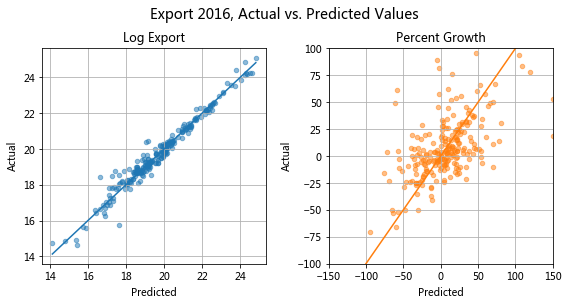

In [8]:
def plot_model_comparison(
    left_data, right_data, left_x, left_y, right_x, right_y, title, left_title, right_title,
    left_refline=None, right_refline=None, left_scale=None, right_scale=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plt.suptitle(title, y=1.05, size=14)
    
    def plot_prediction(data, x, y, ax, title, c='C0', refline=None, scale=None):
        data.plot(ax=axes[ax], x=x, y=y, kind='scatter', alpha=0.5, c=c, title=title)
        if refline is None:
            x_min, x_max = data[x].min(), data[x].max()
            axes[ax].plot([x_min, x_max], [x_min, x_max], c)
        else:
            axes[ax].plot(refline, refline, c)
        if scale is not None:
            axes[ax].axis(scale)
        axes[ax].set_xlabel('Predicted')
        axes[ax].set_ylabel('Actual')
        axes[ax].grid()
        return
    
    plot_prediction(data=left_data, x=left_x, y=left_y, ax=0, title=left_title,
                    refline=left_refline, scale=left_scale)
    plot_prediction(data=right_data, x=right_x, y=right_y, ax=1, title=right_title,
                    c='C1', refline=right_refline, scale=right_scale)
    plt.tight_layout()
    plt.show()
    return

rs1 = model1.result
plot_model_comparison(
    left_data=rs1, right_data=rs1, left_x='ex_pred', left_y='ex',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Export {}, Actual vs. Predicted Values'.format(model1.test_year),
    left_title='Log Export', right_title='Percent Growth', right_refline=[-100, 100],
    right_scale=[-150, 150, -100, 100])

---

## Model 2: Multivariate Regression on All Percent Changes

(a) Using mean-normalized features  
(b) Without mean normalization

#### EDA

In [9]:
lr_df2 = lr_df[['ex_growth', 'gdp_growth', 'gdp_capita_growth', 'im_growth']]

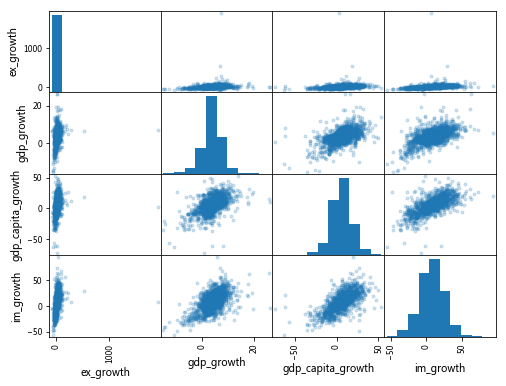

Correlation coefficients:

                    ex_growth  gdp_growth  gdp_capita_growth  im_growth
ex_growth           1.000000    0.208989           0.208874   0.270816
gdp_growth          0.208989    1.000000           0.535455   0.569576
gdp_capita_growth   0.208874    0.535455           1.000000   0.660767
im_growth           0.270816    0.569576           0.660767   1.000000


In [10]:
scatter_matrix(lr_df2, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', lr_df2.corr())

Clearly there are a number of extreme values. Try removing them and see if things get better.

Removed 44 outliers.


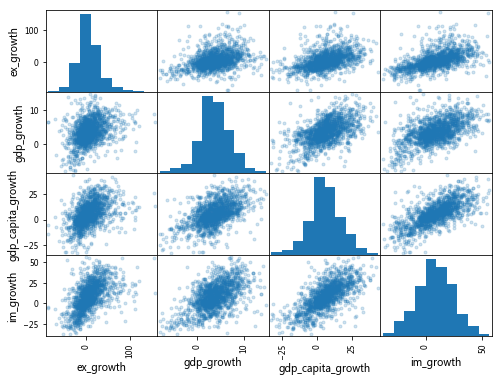

Correlation coefficients:

                    ex_growth  gdp_growth  gdp_capita_growth  im_growth
ex_growth           1.000000    0.347435           0.432214   0.539894
gdp_growth          0.347435    1.000000           0.531836   0.546382
gdp_capita_growth   0.432214    0.531836           1.000000   0.679052
im_growth           0.539894    0.546382           0.679052   1.000000


In [11]:
non_outlier = ((np.abs((lr_df2 - lr_df2.mean()) / lr_df2.std()) < 3)
               .apply(lambda x: reduce(np.logical_and, x), axis=1))
outlier_rm = lr_df2[non_outlier]
print('Removed {} outliers.'.format(len(lr_df2) - len(outlier_rm)))

scatter_matrix(outlier_rm, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', outlier_rm.corr())

Now it looks much better.

### (a) Using Mean-Normalized Features

- Train: 1,377 data points of 80 countries from 1998 throuth 2015.
- Test: 78 data points of 78 countries from 2016 throuth 2016.

Coefficients:

gdp_growth       :  0.8024
gdp_capita_growth:  0.1260
im_growth        :  0.7278

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    78       |         78       |
| mean  |    -7.1055  |         -1.92677 |
| std   |    15.9342  |          9.89287 |
| min   |   -51.5306  |        -39.7164  |
| 25%   |   -14.5769  |         -5.28225 |
| 50%   |    -4.19458 |         -1.41329 |
| 75%   |     1.5066  |          3.76523 |
| max   |    31.7928  |         21.677   |
+-------+-------------+------------------+

Training error: 22.0812
Test error    : 15.0446


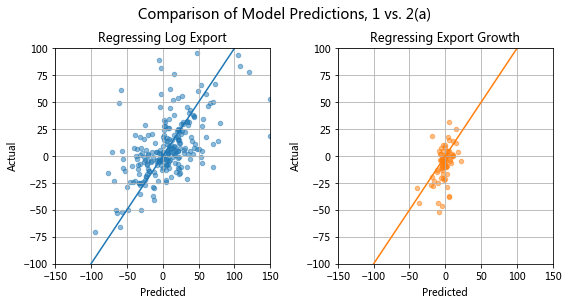

In [12]:
model2a = ExportGrowthModel(data=outlier_rm, predictors=['gdp_growth', 'gdp_capita_growth', 'im_growth'],
                            target='ex_growth', model='lr_growth', normalize=True)
model2a.validate(cv_method='most_recent')
rs2a = model2a.result
plot_model_comparison(
    left_data=rs1, right_data=rs2a, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 1 vs. 2(a)',
    left_title='Regressing Log Export', right_title='Regressing Export Growth',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [13]:
model2a.validate(cv_method='leave_one_out')
model2a.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 21.7036
- Test : 22.7682
Stratified 5-fold cv errors:
- Train: 21.5550
- Test : 23.3504


### (b) Without Mean Normalization

- Train: 1,377 data points of 80 countries from 1998 throuth 2015.
- Test: 78 data points of 78 countries from 2016 throuth 2016.

Coefficients:

gdp_growth       :  0.4410
gdp_capita_growth:  0.2185
im_growth        :  0.7247

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    78       |         78       |
| mean  |    -7.1055  |         -2.07463 |
| std   |    15.9342  |          7.97483 |
| min   |   -51.5306  |        -28.2806  |
| 25%   |   -14.5769  |         -4.67058 |
| 50%   |    -4.19458 |         -1.11621 |
| 75%   |     1.5066  |          2.09469 |
| max   |    31.7928  |         14.7115  |
+-------+-------------+------------------+

Training error: 22.7793
Test error    : 14.5725


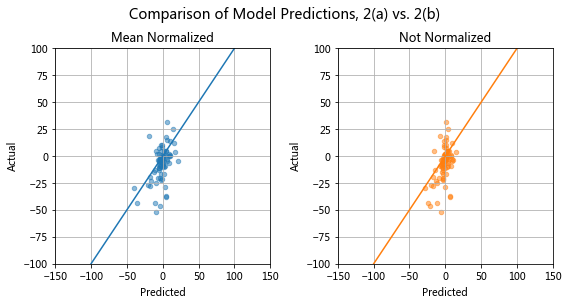

In [14]:
model2b = ExportGrowthModel(data=outlier_rm, predictors=['gdp_growth', 'gdp_capita_growth', 'im_growth'],
                            target='ex_growth', model='lr_growth')
model2b.validate(cv_method='most_recent')
rs2b = model2b.result
plot_model_comparison(
    left_data=rs2a, right_data=rs2b, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 2(a) vs. 2(b)',
    left_title='Mean Normalized', right_title='Not Normalized',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [15]:
model2b.validate(cv_method='leave_one_out')
model2b.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 22.4057
- Test : 22.2365
Stratified 5-fold cv errors:
- Train: 22.4032
- Test : 22.4630


#### Learning Curves: Are More Data Likely to Help?

In [16]:
def learning_curves(model):
    """Plot learning curves for no. of training examples = 1 to 30% of the dataset.
    
    Parameters
    ----------
    model : ExportGrowthModel object
    """
    
    n_trains = range(1, round(len(model.data) * .3), 5)
    train_errors = []
    test_errors = []
    for n_train in n_trains:
        model.validate(cv_method='sampling', n_train=n_train)
        train_errors.append(model.train_error)
        test_errors.append(model.test_error)
    curve_dt = pd.DataFrame(dict(n_train=n_trains, train_error=train_errors, test_error=test_errors))
    curve_dt.plot(x='n_train', y=['train_error', 'test_error'])
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend(['Train', 'Test'])
    plt.show()
    return

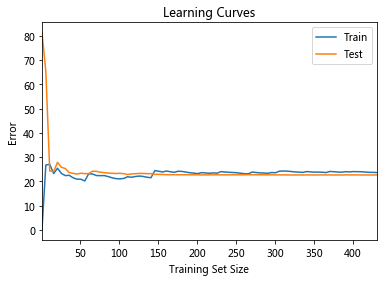

In [17]:
learning_curves(model2b)

Not surprisingly, model 2(b) has high bias. Thus a test error of around 22 percentage point is the best we can expect from it.

#### Error Analysis

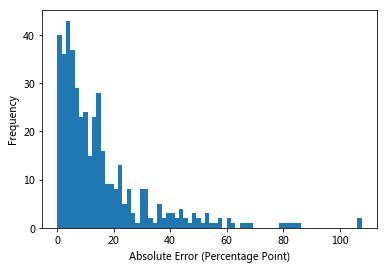

In [18]:
model2b.validate(cv_method='sampling', n_train=round(len(outlier_rm) * .7))
model2b_rs = model2b.result
model2b_rs['ae'] = (model2b_rs['ex_growth'] - model2b_rs['ex_growth_pred']).abs()

model2b_rs['ae'].plot(kind='hist', bins=70)
plt.xlabel('Absolute Error (Percentage Point)')
plt.show()

In [19]:
mae = model2b_rs[['ae']].groupby(level='country').mean().sort_values('ae', ascending=False)
faroff = mae.head(10)
closest = mae.tail(10).iloc[::-1, :]
print('Countries with the most far-off predicted values on average:\n\n{:2}  {:23}  {:5}'
      .format('', 'Country', 'AE'))
for lab, row in faroff.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(faroff.index.get_loc(lab)+1, lab, row['ae']))
print('\nCountries with the closest predicted values on average:\n\n{:2}  {:23}  {:5}'
      .format('', 'Country', 'AE'))
for lab, row in closest.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(closest.index.get_loc(lab)+1, lab, row['ae']))

Countries with the most far-off predicted values on average:

    Country                  AE   
 1. Mozambique             : 70.10
 2. Ghana                  : 43.87
 3. Lao People's Dem. Rep. : 40.77
 4. Costa Rica             : 40.24
 5. United Rep. of Tanzania: 35.11
 6. Panama                 : 30.69
 7. Uruguay                : 30.21
 8. Portugal               : 27.89
 9. Ireland                : 26.23
10. Lithuania              : 25.66

Countries with the closest predicted values on average:

    Country                  AE   
 1. Ecuador                :  3.77
 2. Chile                  :  4.11
 3. Bangladesh             :  4.19
 4. Thailand               :  4.92
 5. Italy                  :  5.32
 6. Australia              :  5.56
 7. Pakistan               :  5.68
 8. Argentina              :  5.78
 9. Colombia               :  5.78
10. Malaysia               :  5.85


In [20]:
mae['group'] = pd.cut(zscore(mae.pow(1/4)).reshape((len(mae),)),
                      bins=range(-2, 5), labels=range(1, 7), include_lowest=True)
anova_dt = (read_lr_data()[['gdp_growth', 'ex', 'gdp_capita', 'im']].groupby(level='country').mean()
            .merge(mae, left_index=True, right_index=True))

def oneway_anova(variable):
    gps = []
    for g in range(5):
        gps.append(anova_dt.loc[anova_dt['group'] == g+1, variable].values)
    return f_oneway(*gps)

variables = sorted(anova_dt.columns.drop(['ae', 'group']))
print('{:10}  {:11} {:7}'.format('Variable', 'F-statistic', 'p-value'))
for x in zip(variables, map(oneway_anova, variables)):
    print('{:10}: {:11.4f} {:7.4f}'.format(x[0], x[1][0], x[1][1]))

Variable    F-statistic p-value
ex        :      0.8005  0.5287
gdp_capita:      1.7657  0.1448
gdp_growth:      1.1264  0.3507
im        :      1.8499  0.1283


---

## Model 3: SVR

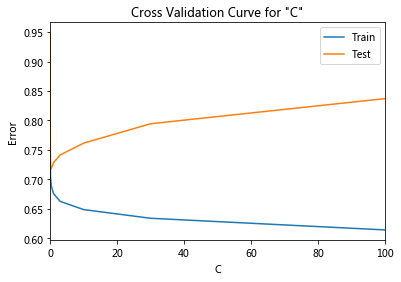

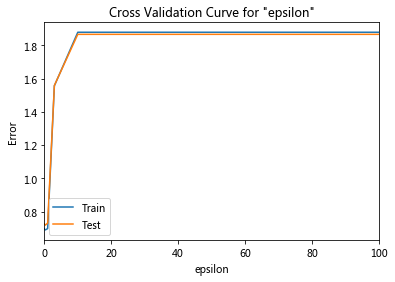

Best parameters:
- C      : 0.3
- epsilon: 0.3


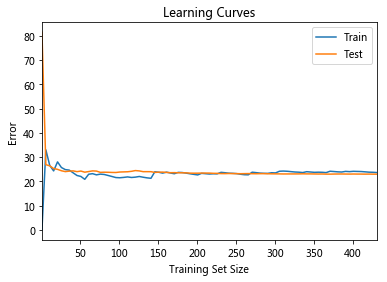

In [21]:
model3 = ExportGrowthModel(data=outlier_rm, predictors=['gdp_growth', 'gdp_capita_growth', 'im_growth'],
                           target='ex_growth', model='svr', scale=True, kernel='rbf')
model3.fit(optimize=True,
           param_grid=dict(C=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                           epsilon=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]),
           verbose=True)
learning_curves(model3)

In [22]:
model3.validate(cv_method='leave_one_out')
model3.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 22.2859
- Test : 22.6343
Stratified 5-fold cv errors:
- Train: 22.2567
- Test : 22.6926


---

## Model 4: Random Forests

In [23]:
def make_dummy_frame(data):
    dummies = pd.get_dummies(data.index.get_level_values('country'), prefix='dummy', drop_first=True)
    dummies.index = data.index
    ddf = pd.concat([data, dummies], axis=1)
    return ddf

ddf = make_dummy_frame(outlier_rm)

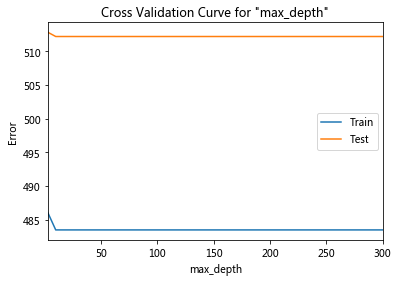

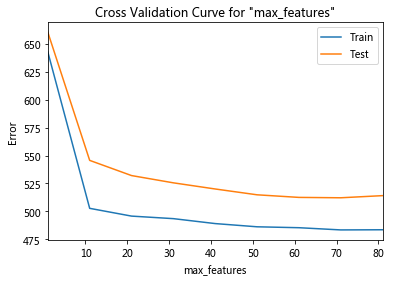

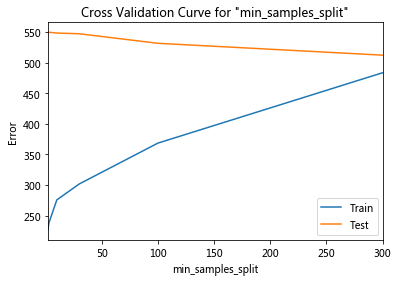

Best parameters:
- max_depth        :  10
- max_features     :  71
- min_samples_split: 300


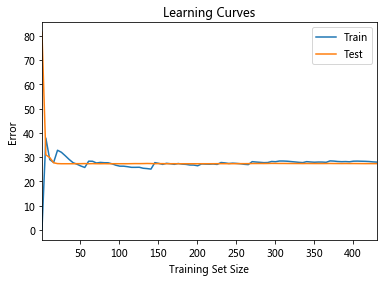

In [24]:
model4 = ExportGrowthModel(data=ddf, predictors=ddf.columns[1:], target='ex_growth',
                           model='rf', n_estimators=100, random_state=3, n_jobs=-1)
model4.fit(optimize=True,
           param_grid=dict(max_features=list(range(1, len(ddf.columns)))[::10],
                           max_depth=[3, 10, 30, 100, 300],
                           min_samples_split=[2, 3, 10, 30, 100, 300]),
           verbose=True)
learning_curves(model4)

In [25]:
model4.validate(cv_method='leave_one_out')
model4.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 21.8894
- Test : 22.3714
Stratified 5-fold cv errors:
- Train: 21.9868
- Test : 22.6110


---

## Model 5: AdaBoost

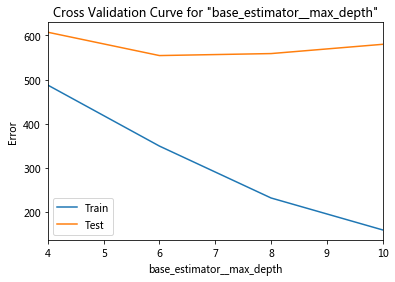

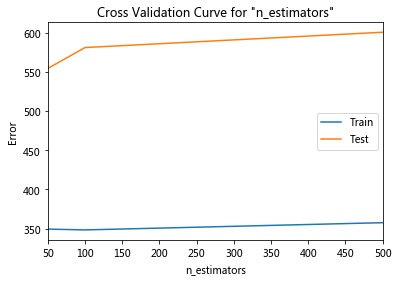

Best parameters:
- base_estimator__max_depth:  6
- n_estimators             : 50


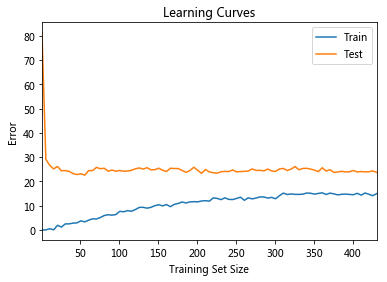

In [26]:
model5 = ExportGrowthModel(data=ddf, predictors=ddf.columns[1:], target='ex_growth',
                           model='ada', random_state=3, learning_rate=1)
model5.fit(optimize=True,
           param_grid=dict(base_estimator__max_depth=[4, 6, 8, 10],
                           n_estimators=[50, 100, 500]),
           verbose=True)
learning_curves(model5)

In [27]:
model5.validate(cv_method='leave_one_out')
model5.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 19.1626
- Test : 24.0555
Stratified 5-fold cv errors:
- Train: 18.6894
- Test : 23.5594


---

## Model 6: Gradient Boosting

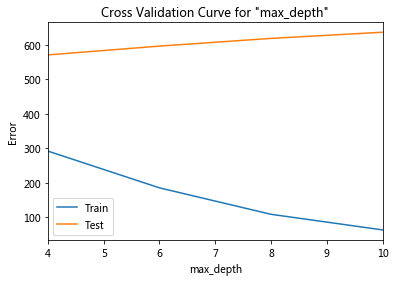

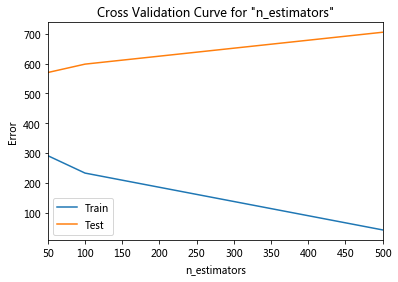

Best parameters:
- max_depth   :  4
- n_estimators: 50


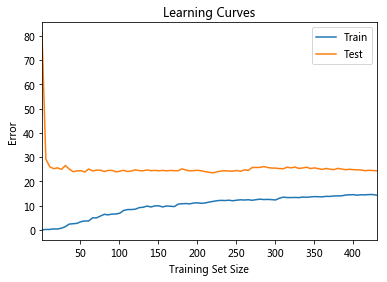

In [28]:
model6 = ExportGrowthModel(data=ddf, predictors=ddf.columns[1:], target='ex_growth',
                           model='gbrt', random_state=3, learning_rate=0.1)
model6.fit(optimize=True,
           param_grid=dict(max_depth=[4, 6, 8, 10],
                           n_estimators=[50, 100, 500]),
           verbose=True)
learning_curves(model6)

In [29]:
model6.validate(cv_method='leave_one_out')
model6.validate(cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 17.5832
- Test : 23.0962
Stratified 5-fold cv errors:
- Train: 17.0666
- Test : 23.8849


---

## Model 7: SARIMA

#### Scrape Monthly Export Data

In [30]:
def get_mof_ts():
    
    current_year = datetime.datetime.now().year - 1911
    url = 'https://portal.sw.nat.gov.tw/APGA/GA06_csv'
    # Suppress InsecureRequestWarning
    requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    def get_data(year):
        payload = {'searchInfo.StartYear': str(year),
                   'searchInfo.EndYear': '',
                   'searchInfo.StartMonth': '1',
                   'searchInfo.EndMonth': '12',
                   'searchInfo.TypeTime': '0',
                   'searchInfo.Type': 'MoneyUSD',
                   'searchInfo.CountryName': '全部國家合計,千里達,土耳其,土庫曼,大溪地,不丹,中非,中國大陸,丹麥,厄瓜多,厄利垂亞,巴布亞紐幾內亞,巴西,巴貝多,巴拉圭,巴林,巴哈馬,巴拿馬,巴勒斯坦,巴基斯坦,日本,比利時,牙買加,以色列,加拿大,加彭,北韓,卡達,古巴,史瓦濟蘭,尼日,尼加拉瓜,尼泊爾,布吉納法索,未列名法屬中美洲領域,未列名美屬中美洲領域,未列名美屬太平洋領域,未列名英屬中美洲領域,瓜地馬拉,甘比亞,白俄羅斯,立陶宛,伊拉克,伊朗,冰島,列支敦斯登,匈牙利,印尼,印度,吉布地,吉里巴斯,吉爾吉斯,吐瓦魯,多米尼克,多明尼加,多哥,安地卡,安圭拉,安哥拉,安道爾,衣索比亞,西班牙,西撒哈拉,克羅埃西亞,利比亞,宏都拉斯,希臘,沙烏地阿拉伯,汶萊,貝里斯,貝南,赤道幾內亞,辛巴威,亞美尼亞,亞塞拜然,其他大洋洲國家,其他中東及近東國家,其他中美洲國家,其他北美洲國家,其他亞洲國家,其他非洲國家,其他南美洲國家,其他國家,其他歐洲國家,坦尚尼亞,奈及利亞,委內瑞拉,孟加拉,尚比亞,帛琉,拉脫維亞,東加,波士尼亞赫塞哥維納,波札那,波多黎各,波蘭,法國,法屬圭亞那,肯亞,芬蘭,阿拉伯聯合大公國,阿根廷,阿曼,阿富汗,阿爾及利亞,阿爾巴尼亞,保加利亞,俄羅斯,南非,南韓,南蘇丹,哈薩克,柬埔寨,查德,玻利維亞,科威特,突尼西亞,約旦,美國,美屬薩摩亞,茅利塔尼亞伊斯蘭共和國,英國,迦納,香港,剛果,剛果民主共和國,哥倫比亞,哥斯大黎加,埃及,挪威,格陵蘭,格瑞那達,泰國,海地,烏干達,烏克蘭,烏拉圭,烏茲別克,琉球,秘魯,索馬利亞,索羅門群島,紐西蘭,納米比亞,納維斯,馬利,馬來西亞,馬其頓,馬拉威,馬約特,馬紹爾群島共和國,馬達加斯加,馬爾他,馬爾地夫,捷克,捷克,教廷,敘利亞,莫三比克,荷蘭,喀麥隆,喬治亞,幾內亞,幾內亞比索,斐濟,斯里蘭卡,斯洛伐克,斯洛維尼亞,智利,菲律賓,象牙海岸,越南,塞內加爾,塞席爾,塞爾維亞,塞爾維亞與蒙特內哥羅,塔吉克,奧地利,愛沙尼亞,愛爾蘭,新加坡,新克里多尼亞,獅子山,瑞士,瑞典,萬那杜,義大利,聖文森,聖多美普林西比,聖克里斯多福,聖馬利諾,聖露西亞,葉門,葛摩聯盟,葡萄牙,維德角,蒙古,蒙特內哥羅共和國,蒙瑟拉特,蒲隆地,蓋亞那,寮國,德國,摩洛哥,摩納哥,摩爾多瓦,模里西斯,緬甸,黎巴嫩,墨西哥,澳大利亞,澳門,盧安達,盧森堡,諾魯,賴比瑞亞,賴索托,賽普勒斯,薩伊,薩爾瓦多,薩摩亞,羅馬尼亞,關島,蘇丹,蘇利南,蘇聯',
                   'noData': 'false'}
        resp = requests.post(url, data=payload, verify=False)
        skiprows = None
        # For data after 2016, need to remove header "註：105年起按一般貿易制度編製。"
        if year >= 105: skiprows = 1
        # Get data in bytes, decode, and convert to dataframe
        df = pd.read_csv(StringIO(resp.content.decode(encoding='big5')), skiprows=skiprows)[
            ['日期', '國家', '出口總值']]
        return df

    df_map = map(lambda x: get_data(x), range(92, current_year + 1))
    df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), df_map)

    # Parse into year and month
    df[['year', 'month']] = df['日期'].str.extract('(\d+)年(\d+)月', expand=False)
    # Create DatetimeIndex
    df.index = pd.to_datetime((df['year'].astype(int) + 1911).astype(str) + '-' + df['month'],
                              format='%Y-%m')
    df.index.name = 'date'
    # Keep only useful columns
    df = df[['國家', '出口總值']]
    df.columns = ['country', 'export']
    # Reshape
    df = pd.pivot_table(df, index=df.index, columns='country', values='export', fill_value=0)

    # Sum of southbound eighteen and ten
    eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡',
                '柬埔寨', '汶萊', '泰國', '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
    ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
    df['十八國'] = df.loc[:, eighteen].sum(axis=1)
    df['十國'] = df.loc[:, ten].sum(axis=1)
    df.to_csv('export_ts.csv', encoding='utf-8')
    return

# get_mof_ts()
ts = pd.read_csv('export_ts.csv', index_col='date', parse_dates=True)

# Filter for target countries
path = 'C:/Users/2093/Desktop/Data Center/07. 出口預測/2017/data/'
target_ctry = list(pd.read_csv(path + 'target_ctry_list.csv', engine='python', header=None)[0].values)
ts = ts[target_ctry]

# Keep only columns with all nonzeros
ts_nonzero = ts.loc[:, ts.all()].copy()

#### Case Study: USA

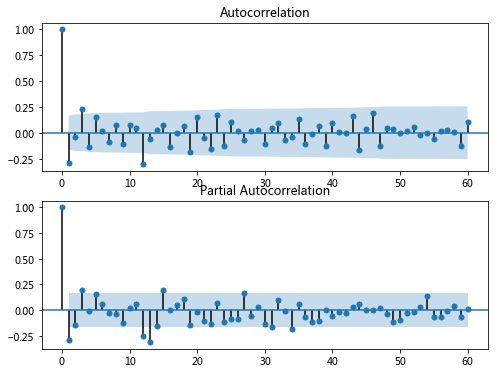

In [31]:
%matplotlib inline

test_year = 2016
x = ts[['美國']].copy()
lx = np.log(x.loc[:str(test_year-1)])
dlx = lx - lx.shift()
ddlx = dlx - dlx.shift(12)
ddlx.dropna(inplace=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ddlx, ax=ax1, lags=60)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ddlx, ax=ax2, lags=60)

Both ACF and PACF appear to tail off at seasonal and non-seasonal lags. We'll use grid search to fit the parameters.

In [32]:
def optimize_aic(ts, max_order=2, max_seasonal_order=1):

    def aic(ts, params):
        p, q, P, Q = params
        try:
            fit = sm.tsa.statespace.SARIMAX(ts, order=(p, 1, q), seasonal_order=(P, 1, Q, 12)).fit()
        except (ValueError, np.linalg.LinAlgError):
            return p, q, P, Q, None
        return p, q, P, Q, fit.aic
    
    gridpoints = list(product(range(max_order+1), range(max_order+1),
                              range(max_seasonal_order+1), range(max_seasonal_order+1)))
    rs = pd.DataFrame(list(map(lambda x: aic(ts, x), gridpoints)))
    rs.columns = ['p', 'q', 'P', 'Q', 'aic']
    p, q, P, Q = tuple(int(x) for x in rs.ix[rs['aic'].idxmin(), 'p':'Q'].values)
    return p, q, P, Q

C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                 美國   No. Observations:                  156
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 191.079
Date:                            Fri, 02 Jun 2017   AIC                           -370.158
Time:                                    15:11:48   BIC                           -351.859
Sample:                                01-01-2003   HQIC                          -362.726
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0075      0.142     -7.071      0.000      -1.287      -0.728
ar.L2         -0.6323      0.129   

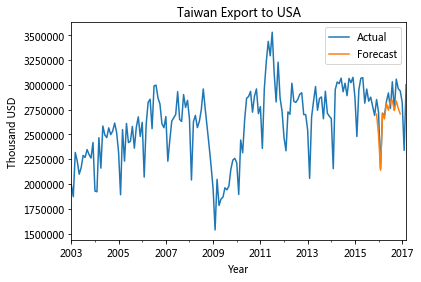

In [33]:
%%time

p, q, P, Q = optimize_aic(lx)
rs = sm.tsa.statespace.SARIMAX(lx, order=(p, 1, q), seasonal_order=(P, 1, Q, 12)).fit(
    mle_regression=True, warn_convergence=True)
print(rs.summary(), '\n')
x['forecast'] = np.exp(
    rs.predict(start='{}-12-01'.format(test_year-1), end='{}-12-01'.format(test_year), dynamic=True))
x.plot()
plt.title('Taiwan Export to USA')
plt.xlabel('Year')
plt.ylabel('Thousand USD')
plt.legend(['Actual', 'Forecast'])

#### Automation

In [34]:
def sarima_for(x, n_years=1):
    """Search for optimal SARIMA parameters and make forecasts.
    
    - Takes a Series and returns a Series. Intended to be applied to each column of a DataFrame
      that represents a multi-dimensional time series.
    - Auto log-transforms input (zeros are replaced with a very small number, 1e-6) and returns
      inversed-transformed forecasts.
    
    Parameters
    ----------
    n_years : int, optional (default=1)
        Number of years ahead to make predictions for.
    """
    
    lx = np.log(x.replace(0, 1e-6))
    p, q, P, Q = optimize_aic(lx, max_order=3, max_seasonal_order=1)
    fit = (sm.tsa.statespace.SARIMAX(lx, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))
           .fit(mle_regression=True, warn_convergence=True))
    last_date = x.index.max()
    forecast = np.exp(
        fit.predict(start=last_date, end='{}-12-01'.format(last_date.year+n_years), dynamic=True)[1:])
    return forecast

def pct_change(ts, forecast=True, n_years=1):
    """Take a multi-dimensional time series and return predicted percent change
    for the next year not in data.
    
    Parameters
    ----------
    forecast : boolean, optional (default=True)
        If False, assume the series passed is complete and compute percent changes based on
        the last two years, without forecasting.
    
    n_years : int, optional (default=1)
        Number of years ahead to compute percent changes (and make predictions for if forecast=True).
    """
    
    if forecast:
        forecast = ts.apply(sarima_for, n_years=n_years)
        ts = ts.append(forecast)
    last_year = ts.index.year.max()
    change = (ts.loc[str(last_year-n_years):str(last_year)]
              .resample('A').sum().pct_change() * 100).loc[str(last_year-n_years+1):str(last_year)].T
    return change

def backtest(ts, test_year):
    """Backtest performance of time series model.
    
    Parameters
    ----------
    test_year : integer
        Can be any year contained in data except the last year, which in most cases does not
        include data for all twelve months.
    """
    
    last_month = datetime.datetime.now().month - 1
    actual = ts.loc[:'{}'.format(test_year)]
    train = actual.loc[:'{}-{}'.format(test_year-1, last_month)]
    
    actual_growth = pct_change(actual, forecast=False)
    pred_growth = pct_change(train)
    actual_pred = pd.concat([actual_growth, pred_growth], axis=1)
    error = np.sqrt((actual_pred.replace(np.inf, np.nan).dropna().diff(axis=1) ** 2).mean()).values[1]
    print('Backtesting done on {} (RMSE: {:.4f}), {}'.format(
            test_year, error, datetime.datetime.now().strftime('%c')))
    return error

In [6]:
%%time

bt_start, bt_end = 2011, 2016
bt_errors = pd.Series([backtest(ts_nonzero, y) for y in range(bt_start, bt_end+1)])
print('RMSE for {} countries, cross-validated over {} years ({}-{}): {:.4f}'
      .format(len(ts_nonzero.columns), bt_end-bt_start+1, bt_start, bt_end, bt_errors.mean()))

C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Backtesting done on 2011 (RMSE: 28.5494), Fri May 26 15:45:35 2017
Backtesting done on 2012 (RMSE: 27.7000), Fri May 26 16:00:57 2017
Backtesting done on 2013 (RMSE: 213.2265), Fri May 26 16:16:59 2017
Backtesting done on 2014 (RMSE: 35.4735), Fri May 26 16:34:30 2017
Backtesting done on 2015 (RMSE: 27.1171), Fri May 26 16:52:36 2017
Backtesting done on 2016 (RMSE: 24.0134), Fri May 26 17:11:53 2017
RMSE for 80 countries, cross-validated over 6 years (2011-2016): 59.3466
Wall time: 1h 40min 25s


---

## Model 8: Neural Network

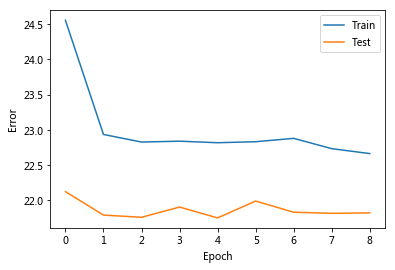

In [35]:
def train_nn(X, y):
    """Return a fitted neural network together with training and validation errors.
    
    Parameters
    ----------
    X, y : DataFrame
    """
    
    input_shape = (X.shape[1],)
    nn = Sequential()
    nn.add(Dense(100, activation='relu', input_shape=input_shape))
    nn.add(Dense(100, activation='relu'))
    nn.add(Dense(1))
    nn.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping_monitor = EarlyStopping(patience=3)
    nn_rs = nn.fit(X.values, y.values, validation_split=0.4, epochs=20,
                   callbacks=[early_stopping_monitor], verbose=False)
    return nn, nn_rs

nn, nn_rs = train_nn(ddf.drop('ex_growth', axis=1), ddf[['ex_growth']])
plt.plot(np.sqrt(nn_rs.history['loss']), 'C0', np.sqrt(nn_rs.history['val_loss']), 'C1')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Train', 'Test'])
plt.show()

---

## Ensemble 1: Averaging Ensemble

## Ensemble 2: One Best Model per Country

In [36]:
def stack_pred(train, pred):
    """Stack model predictions. 
    
    Models included:
      - Multivariate linear regression on all percent changes
      - SVR
      - Random forest
      - AdaBoost
      - Gradient boosting
      - SARIMA
      - Neural network
      
    For each model, predictions are appended as a separate column to the original datasets.
    
    Parameters
    ----------
    train : DataFrame
        Training set to be split into folds by year. Stacker will train each model on the folds
        and then make predictions on the left-out fold.
        
    pred : DataFrame
        Prediction set. Each time a model is trained on one of the folds, a set of predictions
        is made. All sets of predictions will then be averaged to obtain the final predictions
        for the current model.
    """
    
    year_level = train.index.get_level_values('year').year
    n_years = pd.Series(year_level).nunique()
    preds = pd.DataFrame()
    counter = 1
    
    for yr in pd.Series(year_level).unique():
        fold_idx = year_level != yr
        oof_idx = year_level == yr
        fold = train.loc[idx[fold_idx, :]]
        oof = train.loc[idx[oof_idx, :]]
        
        print('Iteration {}/{}: out-of-fold {}...'.format(counter, n_years, yr))
        
        # Multivariate linear regression
#         model = ExportGrowthModel(train, predictors=['gdp_growth', 'gdp_capita', 'im'], target='ex',
#                                   model='lr_export', normalize=True)
#         model.fit(fold[model.predictors], fold[[model.target]])
#         train.loc[idx[oof_idx, :], 'ex_growth_lr_ex'] = model.predict(oof[model.predictors])
#         pred['ex_growth_lr_ex'] = model.predict(pred[model.predictors])
        
        # Multivariate linear regression on all percent changes
        model = ExportGrowthModel(train, predictors=['gdp_growth', 'gdp_capita_growth', 'im_growth'],
                                  target='ex_growth', model='lr_growth', normalize=False)
        model.fit(fold[model.predictors], fold[[model.target]])
        train.loc[idx[oof_idx, :], 'ex_growth_lr_g'] = (model.predict(oof[model.predictors])
                                                        .rename(columns={'ex_growth':'ex_growth_lr_g'}))
        preds = pd.concat([preds, (model.predict(pred[model.predictors])
                                   .rename(columns={'ex_growth':'ex_growth_lr_g'}))], axis=1)
            
        # SVR
        model = ExportGrowthModel(train, predictors=['gdp_growth', 'gdp_capita_growth', 'im_growth'],
                                  target='ex_growth', model='svr', kernel='rbf', scale=True)
        model.fit(fold[model.predictors], fold[[model.target]], optimize=True,
                  param_grid=dict(C=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                                  epsilon=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]))
        train.loc[idx[oof_idx, :], 'ex_growth_svr'] = (model.predict(oof[model.predictors])
                                                       .rename(columns={'ex_growth':'ex_growth_svr'}))
        preds = pd.concat([preds, (model.predict(pred[model.predictors])
                                   .rename(columns={'ex_growth':'ex_growth_svr'}))], axis=1)
        
        # Random forest
        predictors = (['gdp_growth', 'gdp_capita_growth', 'im_growth']
                      + list(train.columns[train.columns.str.contains('dummy')]))
        model = ExportGrowthModel(train, predictors=predictors, target='ex_growth',
                                  model='rf', n_estimators=100, random_state=3, n_jobs=-1)
        model.fit(fold[model.predictors], fold[[model.target]], optimize=True,
                  param_grid=dict(max_features=list(range(1, len(ddf.columns)))[::10],
                                  max_depth=[3, 10, 30, 100, 300],
                                  min_samples_split=[2, 3, 10, 30, 100, 300]))
        train.loc[idx[oof_idx, :], 'ex_growth_rf'] = (model.predict(oof[model.predictors])
                                                      .rename(columns={'ex_growth':'ex_growth_rf'}))
        preds = pd.concat([preds, (model.predict(pred[model.predictors])
                                   .rename(columns={'ex_growth':'ex_growth_rf'}))], axis=1)
        
        # AdaBoost
        model = ExportGrowthModel(train, predictors=predictors, target='ex_growth',
                                  model='ada', random_state=3, learning_rate=1)
        model.fit(fold[model.predictors], fold[[model.target]], optimize=True,
                  param_grid=dict(base_estimator__max_depth=[4, 6, 8, 10],
                                  n_estimators=[50, 100, 500]))
        train.loc[idx[oof_idx, :], 'ex_growth_ada'] = (model.predict(oof[model.predictors])
                                                       .rename(columns={'ex_growth':'ex_growth_ada'}))
        preds = pd.concat([preds, (model.predict(pred[model.predictors])
                                   .rename(columns={'ex_growth':'ex_growth_ada'}))], axis=1)

        # Gradient boosting
        model = ExportGrowthModel(train, predictors=predictors, target='ex_growth',
                                  model='gbrt', random_state=3, learning_rate=0.1)
        model.fit(fold[model.predictors], fold[[model.target]], optimize=True,
                  param_grid=dict(max_depth=[4, 6, 8, 10],
                                  n_estimators=[50, 100, 500]))
        train.loc[idx[oof_idx, :], 'ex_growth_gbrt'] = (model.predict(oof[model.predictors])
                                                        .rename(columns={'ex_growth':'ex_growth_gbrt'}))
        preds = pd.concat([preds, (model.predict(pred[model.predictors])
                                   .rename(columns={'ex_growth':'ex_growth_gbrt'}))], axis=1)
        
        # SARIMA
        if yr >= 2005:
            sarima_rs = pct_change(ts.loc[:str(yr-1)])
            sarima_rs.index = pd.Series(sarima_rs.index).map(ctry_name_map_rev)
            sarima_rs.columns = [pd.to_datetime(str(yr) + '-01-01', format='%Y-%m-%d')]
            sarima_rs = sarima_rs.stack().swaplevel(0, 1).sort_index()
            sarima_rs.index.names = ['year', 'country']
            train.loc[idx[oof_idx, :], 'ex_growth_sarima'] = sarima_rs
        
        # Neural network
        nn, nn_rs = train_nn(fold[predictors], fold[['ex_growth']])
        train.loc[idx[oof_idx, :], 'ex_growth_nn'] = nn.predict(oof[predictors].values)
        preds = pd.concat([preds, pd.Series(nn.predict(pred[predictors].values).ravel(),
                                            index=pred.index,
                                            name='ex_growth_nn')], axis=1)
        
        counter += 1
        
    for c in ['ex_growth_lr_g', 'ex_growth_svr', 'ex_growth_rf', 'ex_growth_ada', 'ex_growth_gbrt',
              'ex_growth_nn']:
         pred[c] = preds[c].mean(axis=1)

    # SARIMA
    sarima_rs = pct_change(ts.loc[:str(year_level.max())], n_years=2)
    sarima_rs.index = pd.Series(sarima_rs.index).map(ctry_name_map_rev)
    sarima_rs.columns = list(pred.index.get_level_values('year').unique())
    sarima_rs = sarima_rs.stack().swaplevel(0, 1).sort_index()
    sarima_rs.index.names = ['year', 'country']
    pred['ex_growth_sarima'] = sarima_rs
    
    return train, pred

In [37]:
%%time

train = ddf.copy()
pred = make_dummy_frame(pred[['ex_growth', 'gdp_growth', 'gdp_capita_growth', 'im_growth']]).copy()

train, pred = stack_pred(train, pred)
train.to_csv(path + 'stacking_train.csv', encoding='utf-8')
pred.to_csv(path + 'stacking_pred.csv', encoding='utf-8')

Iteration 1/19: out-of-fold 1998...
Iteration 2/19: out-of-fold 1999...
Iteration 3/19: out-of-fold 2000...
Iteration 4/19: out-of-fold 2001...
Iteration 5/19: out-of-fold 2002...
Iteration 6/19: out-of-fold 2003...
Iteration 7/19: out-of-fold 2004...
Iteration 8/19: out-of-fold 2005...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:928: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x

Iteration 9/19: out-of-fold 2006...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 10/19: out-of-fold 2007...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 11/19: out-of-fold 2008...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 12/19: out-of-fold 2009...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 13/19: out-of-fold 2010...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 14/19: out-of-fold 2011...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 15/19: out-of-fold 2012...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 16/19: out-of-fold 2013...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 17/19: out-of-fold 2014...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 18/19: out-of-fold 2015...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Iteration 19/19: out-of-fold 2016...


C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)


Wall time: 6h 51min 1s


In [38]:
# SARIMA predictions only available for year >= 2005
train = train.loc[idx['2005':'2016', :], :].copy()

def orient_accuracy(data):
    """Return DataFrame of mean orientation accuracy for each model, averaged over all countries,
    with years as rows and models as columns.
    """
    
    orient = data.copy()
    for c in orient.columns[1:]:
        orient[c] = orient[c] * orient['ex_growth']
    orient.drop('ex_growth', axis=1, inplace=True)
    orient_accu = (orient > 0).groupby(level='year').mean()
    return orient_accu

def country_rmse(data):
    """Return DataFrame of mean RMSE for each (country, model) pair, with countries as rows
    and models are columns.
    """
    
    ses = data.copy()
    for c in ses.columns[1:]:
        ses[c] = (ses[c] - ses['ex_growth']) ** 2
    ses.drop('ex_growth', axis=1, inplace=True)
    rmse_ctry = ses.groupby(level='country').mean().pow(.5)
    return rmse_ctry

def compute_ensemble_features(data):
    """Return DataFrame of computed ensemble features.
    
    Ensemble models include:
      - Averaing ensemble:
        First, predictions are assigned to two groups based on their sign. Then a weighted sum
        is calculted to decide whether positive or negative predictions should be considered in
        computing averages.
        The weights used are each model's mean orientation accuracy, i.e. the more accurate a
        model's orientation is, the more its vote counts.
        
      - One best model per country:
        Choose only the prediction made by the best model for each country.
        Best model for a country is defined as the model with the lowest RMSE averaged over all
        predictions for that country.
    """

    ex_growth_cols = train.loc[:, train.columns[train.columns.str.contains('ex_growth')]]
    orient_accu = orient_accuracy(ex_growth_cols)
    orient_accu_mean = orient_accu.mean()
    model_accu_weight = orient_accu_mean / orient_accu_mean.sum()

    rmse_ctry = country_rmse(ex_growth_cols)
    ctry_best_model = rmse_ctry.idxmin(axis=1).to_dict()
    
    data = data.copy()
    data['vote_pos'] = ((data > 0) * model_accu_weight).sum(axis=1) >= 0.5
    wgt_avg = (data
        .apply(lambda row: row.drop('vote_pos')[(row.drop('vote_pos') > 0) == row['vote_pos']].mean(),
               axis=1))
    data['best_model'] = (pd.Series(data.index.get_level_values('country'))
                          .map(ctry_best_model).values)
    best_model_pred = data.apply(lambda row: row[row['best_model']], axis=1)
    en_features = pd.concat([wgt_avg, best_model_pred], axis=1)
    en_features.columns = ['ex_growth_wgtavg', 'ex_growth_ctrybest']
    return en_features

pred = pred.join(compute_ensemble_features(pred.loc[:, pred.columns.str.contains('ex_growth_')]))
train = train.join(compute_ensemble_features(train.drop('ex_growth', axis=1)))

---

## Ensemble 3: Standard Linear Regression Stacking

$$b(x) = \sum_i w_i g_i(x),\forall x$$

In [39]:
ensemble3_predictors = list(train.columns[~train.columns.str.contains('dummy_|ex_growth$')])
ensemble3 = ExportGrowthModel(data=train, predictors=ensemble3_predictors, target='ex_growth',
                              model='lr_growth')
ensemble3.validate(cv_method='most_recent')
print()
ensemble3.validate(cv_method='leave_one_out')
ensemble3.validate(cv_method='skf', n_splits=5)

train['ex_growth_lrstack'] = ensemble3.predict(train[ensemble3_predictors])
pred['ex_growth_lrstack'] = ensemble3.predict(pred[ensemble3_predictors])

- Train: 857 data points of 80 countries from 2005 throuth 2015.
- Test: 78 data points of 78 countries from 2016 throuth 2016.

Coefficients:

gdp_growth        :  3.4477
gdp_capita_growth :  2.3669
im_growth         :  6.5133
ex_growth_lr_g    : -8.3745
ex_growth_svr     : -0.4549
ex_growth_rf      :  0.5205
ex_growth_ada     : -0.1589
ex_growth_gbrt    : -0.0939
ex_growth_nn      : -0.2996
ex_growth_sarima  :  0.1373
ex_growth_wgtavg  : -0.1163
ex_growth_ctrybest:  0.8092

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    78       |       78         |
| mean  |    -7.1055  |       -6.41896   |
| std   |    15.9342  |        8.62811   |
| min   |   -51.5306  |      -35.2723    |
| 25%   |   -14.5769  |      -12.0072    |
| 50%   |    -4.19458 |       -4.69307   |
| 75%   |     1.5066  |        0.0289031 |
| max   |    31.7928  |        7.94447   |
+-------+-------------+---

---

## Ensemble 4: Neural Network

In [40]:
nn, nn_rs = train_nn(train.drop('ex_growth', axis=1), train[['ex_growth']])
train['ex_growth_nnstack'] = nn.predict(train.drop('ex_growth', axis=1).values)
pred['ex_growth_nnstack'] = nn.predict(pred.drop('ex_growth', axis=1).values)

---

## Ensemble 5: Feature-Weighted Linear Stacking (FWLS)

$$b(x) = \sum_{i, j}\ v_{ij}\ f_j(x)\ g_i(x), \forall x$$

where $f_j$ are meta-feature functions.

In [41]:
train.to_csv(path + 'stacked_train.csv', encoding='utf-8')
pred.to_csv(path + 'stacked_pred.csv', encoding='utf-8')

---

## Conclusion: Benchmarking Models

#### Overall Benchmarking

Distribution of model predictions:
         ex_growth  ex_growth_lr_g  ex_growth_svr  ex_growth_rf  ex_growth_ada  \
count  935.000000      935.000000     935.000000    935.000000     935.000000   
mean     6.635830        7.563568       5.344802      7.802540       8.869834   
std     26.699253       15.275048      14.791934     14.363812      17.312014   
min    -84.735515      -33.791316     -28.649704    -21.878336     -42.625205   
25%     -8.679557       -1.752699      -3.625078     -2.168960      -1.895347   
50%      3.586006        7.894192       5.957792      7.283861       9.658220   
75%     19.789329       18.221467      15.517720     19.505681      20.889380   
max    155.588304       51.559713      37.363969     84.153473     154.147757   

       ex_growth_gbrt  ex_growth_nn  ex_growth_sarima  ex_growth_wgtavg  \
count      935.000000    935.000000        935.000000        935.000000   
mean         7.495205      8.114965          9.390523          8.928669   
std      

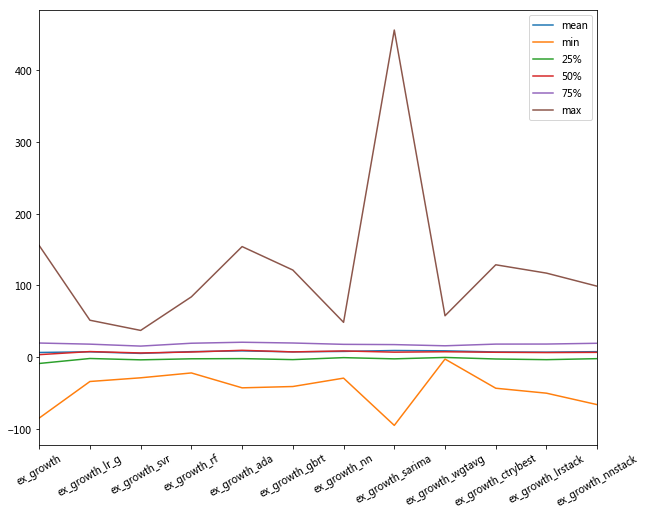

Overall CV RMSE leaderboard:
  1. ex_growth_nnstack : 18.9721
  2. ex_growth_lrstack : 19.8176
  3. ex_growth_ctrybest: 21.0004
  4. ex_growth_nn      : 22.1315
  5. ex_growth_lr_g    : 22.1636
  6. ex_growth_rf      : 22.3926
  7. ex_growth_svr     : 22.4857
  8. ex_growth_wgtavg  : 23.1799
  9. ex_growth_gbrt    : 23.2470
 10. ex_growth_ada     : 23.9694
 11. ex_growth_sarima  : 31.7418


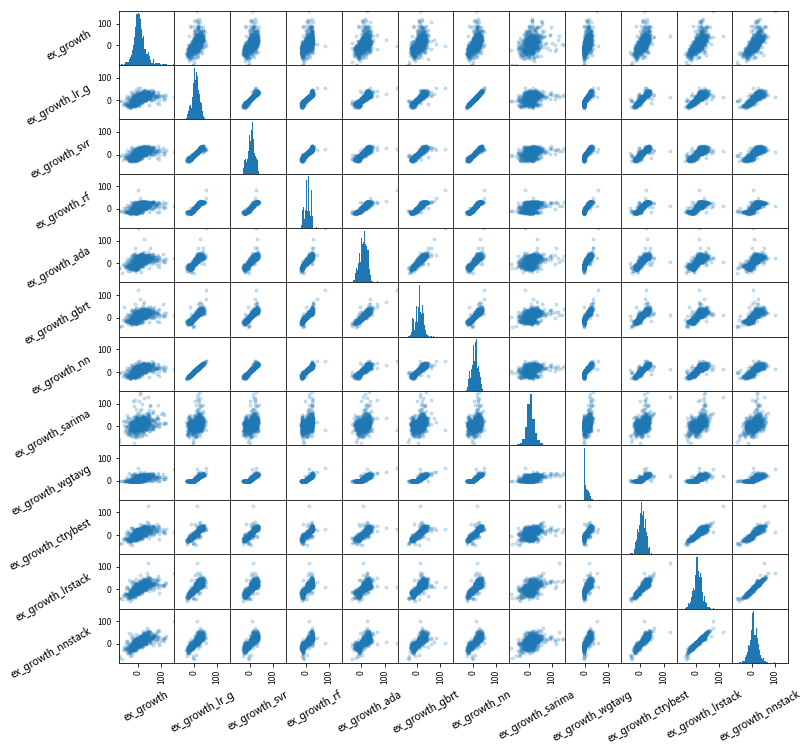

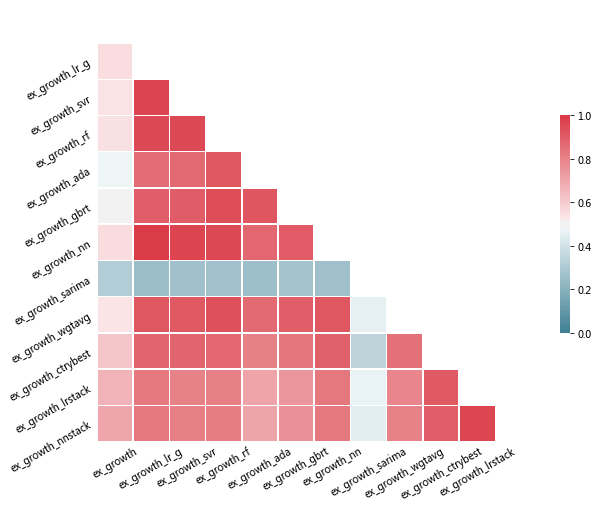

In [42]:
result = train.loc[:, train.columns.str.contains('ex_growth')].copy()

result_summary = result.describe()
print('Distribution of model predictions:\n', result_summary)
result_summary.T.drop(['count', 'std'], axis=1).plot(figsize=(10, 8))
plt.xticks(range(len(result_summary.columns)), list(result_summary.columns), rotation=30)
plt.show()

width = max(map(len, result.columns))
print('Overall CV RMSE leaderboard:')
rmse_lead = pd.Series()
for c in result.columns[1:]:
    rmse_lead = rmse_lead.append(pd.Series(ExportGrowthModel.rmse(result['ex_growth'], result[c]),
                                           index=[c]))
for num, val in enumerate(rmse_lead.sort_values()):
    print('{:3}. {:{width}}: {:.4f}'.format(num+1, rmse_lead.sort_values().index[num], val,
                                            width=width))

axarr = scatter_matrix(result, alpha=0.2, figsize=(12, 12), hist_kwds={'bins': 50})
result_min, result_max = result['ex_growth'].min(), result['ex_growth'].max()
for i, j in [(x, y) for x in range(len(axarr)) for y in range(len(axarr))]:
    axarr[i, j].set_xlim(result_min, result_max)
    axarr[i, j].set_xlabel(axarr[i, j].get_xlabel(), rotation=30)
    axarr[i, j].set_ylabel(axarr[i, j].get_ylabel(), rotation=30, horizontalalignment='right')
    if i != j:
        axarr[i, j].set_ylim(result_min, result_max)
plt.show()

corr = result.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0, square=True,
            xticklabels=list(corr.columns[:-1]) + [''], yticklabels=[''] + list(corr.columns[1:]),
            linewidths=.5, cbar_kws={'shrink': .5}, ax=ax)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.tick_params(axis='both', which='both', length=0)
plt.show()

#### Country-wise Benchmarking

Distribution of country-wise RMSE:
        ex_growth_lr_g  ex_growth_svr  ex_growth_rf  ex_growth_ada  \
count       80.000000      80.000000     80.000000      80.000000   
mean        19.429853      19.732281     19.807765      21.449170   
std         10.934521      11.073835     10.681020      10.822255   
min          5.601876       6.261264      7.451663       8.112406   
25%         11.106698      11.112584     11.737901      13.651278   
50%         15.992858      15.965603     16.968739      18.889737   
75%         23.845311      25.023429     24.349201      26.251274   
max         55.921695      55.727587     52.565498      56.648823   

       ex_growth_gbrt  ex_growth_nn  ex_growth_sarima  ex_growth_wgtavg  \
count       80.000000     80.000000         80.000000         80.000000   
mean        20.510675     19.443741         27.701559         20.807655   
std         11.061921     10.832651         15.553840         10.504014   
min          7.197906      6.185627       

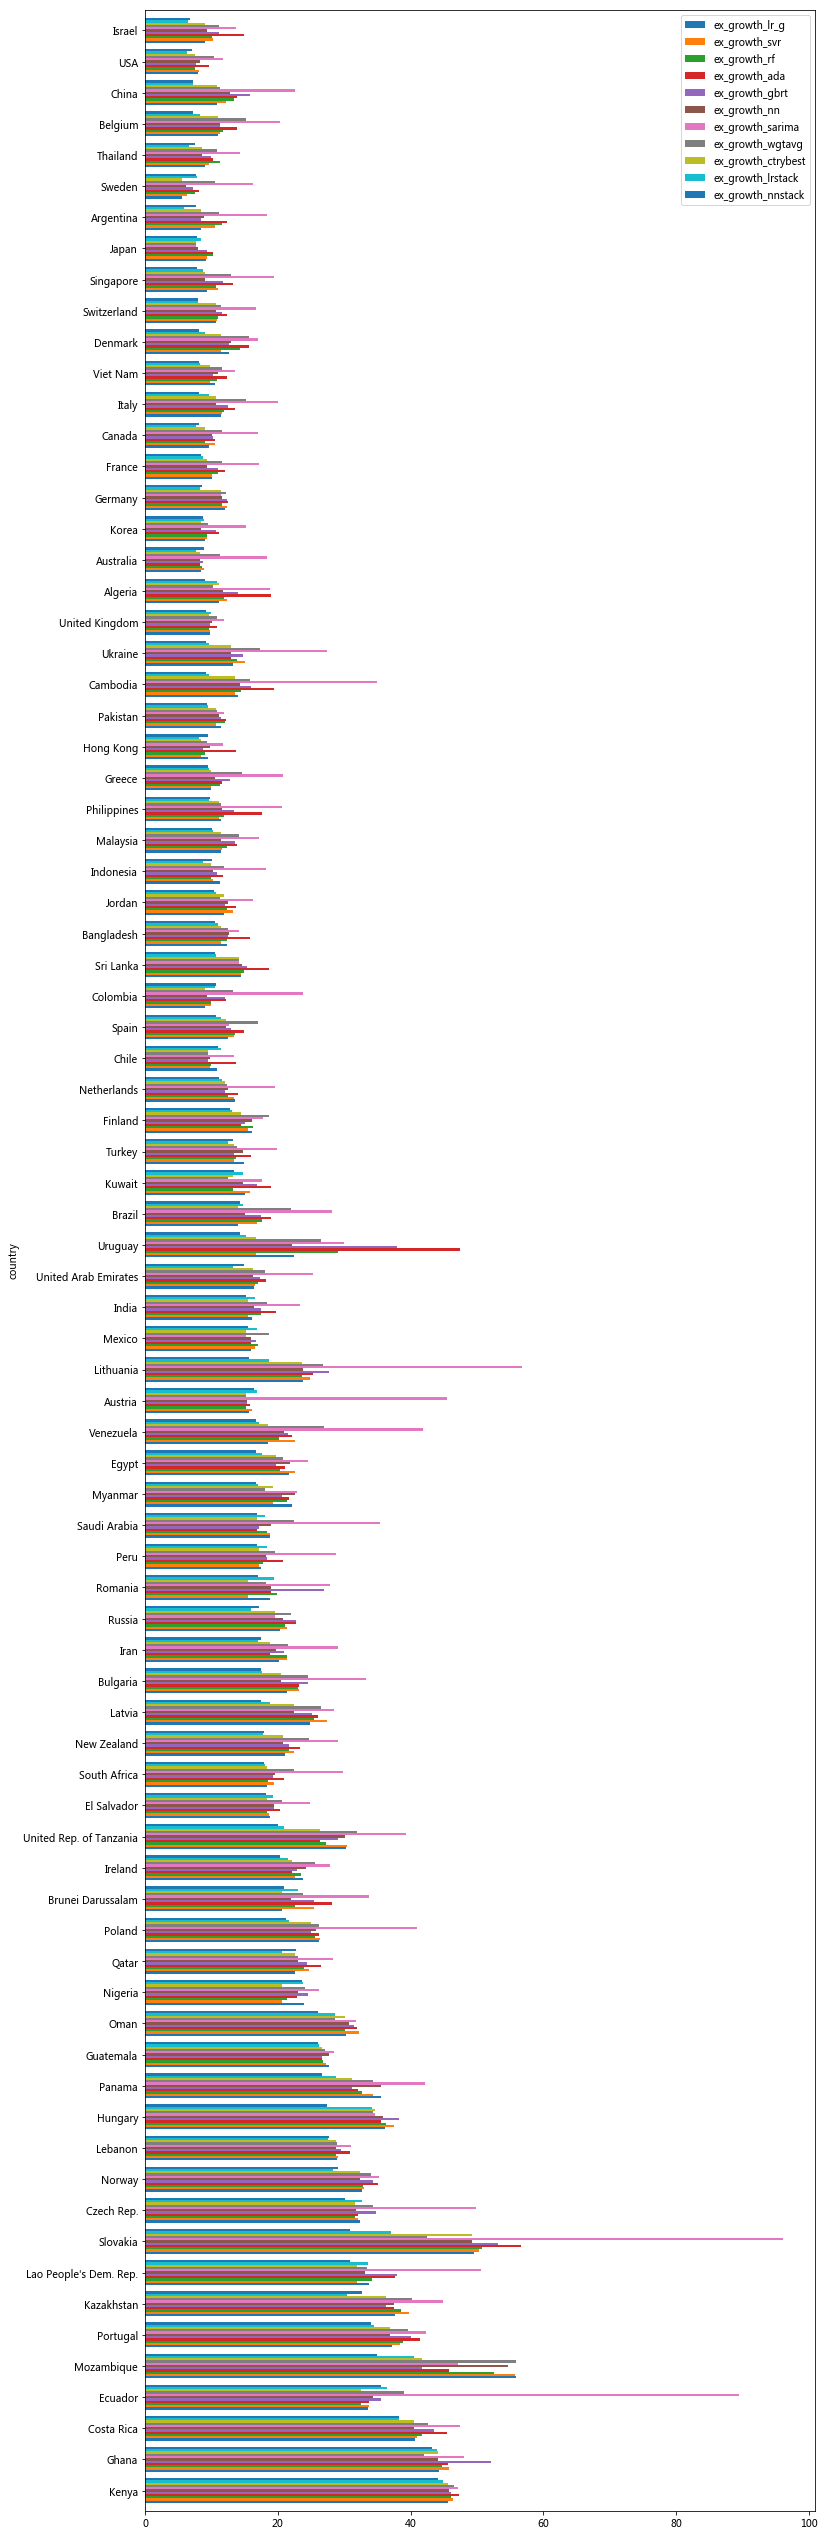

In [43]:
rmse_ctry = country_rmse(result)
print('Distribution of country-wise RMSE:\n', rmse_ctry.describe())

(rmse_ctry.sort_values(rmse_lead.idxmin(), ascending=False)
 .plot(kind='barh', figsize=(12, 46), width=0.8))
plt.show()

#### Orientation Accuracy

Average orientation accuracy leaderboard:
  1. ex_growth_lrstack : 0.7749
  2. ex_growth_ctrybest: 0.7718
  3. ex_growth_wgtavg  : 0.7707
  4. ex_growth_lr_g    : 0.7685
  5. ex_growth_nnstack : 0.7664
  6. ex_growth_nn      : 0.7652
  7. ex_growth_svr     : 0.7624
  8. ex_growth_rf      : 0.7621
  9. ex_growth_ada     : 0.7599
 10. ex_growth_gbrt    : 0.7546
 11. ex_growth_sarima  : 0.6135


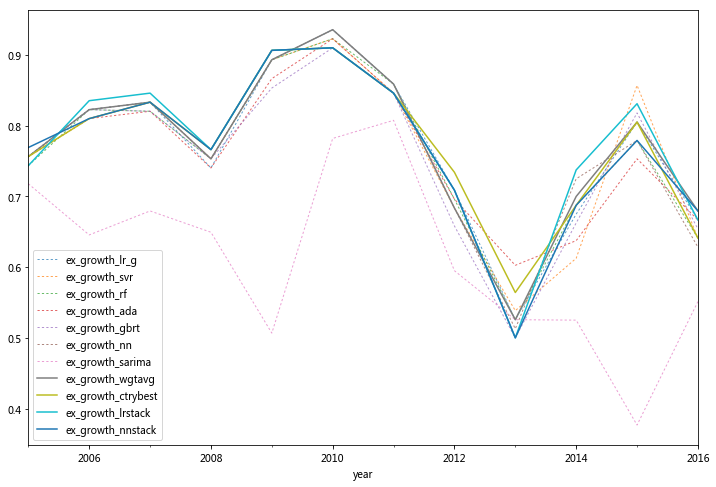

In [44]:
orient_accu = orient_accuracy(result)
orient_accu_mean = orient_accu.mean()
print('Average orientation accuracy leaderboard:')
for num, val in enumerate(orient_accu_mean.sort_values(ascending=False)):
    print('{:3}. {:{width}}: {:.4f}'
          .format(num+1, orient_accu_mean.sort_values(ascending=False).index[num], val, width=width))

fig, ax= plt.subplots()
orient_accu.iloc[:, :7].plot(figsize=(12, 8), style=':', linewidth=1, alpha=0.7, ax=ax)
orient_accu.iloc[:, 7:].plot(style='-', linewidth=1.5, alpha=1, ax=ax)
plt.show()